# HW 3
For this homework, we will be exploring select topics in multivariate time series analysis. The data used in this homework is the same as the previous. Today, we will be taking a look at RT load in MISO and we will be examining it alongside certain meteorological variables that may be highly relevant to load forecasting in the MISO market, including temperature (degrees F), snowfall (in), and wind speed(mph). First, we load in the data and create a subset dataframe including only the relevant variables.

In [1]:
# Numerical/Statistical Libraries
import pandas as pd
import scipy as sp
import numpy as np
import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests

# Plotting Libraries
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

# Various Utilities
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_excel(r"C:\Users\Jared\OneDrive\Mines\FALL2024\EBGN594\MISO_PJM_data\raw_data.xlsx")

In [4]:
df = pd.DataFrame({
    'Date/Time': data['Date/Time'],
    'MISO RT LOAD (MW)': data['MISO RTLOAD'],
    'Temperature (F)': data['temperature'],
    'Snowfall (inch)': data['snowfall (inch)'],
    'Wind Speed (mph)': data['wind_speed_100m (mp/h)']
})

df.set_index('Date/Time', inplace=True)

df.head()

,MISO RT LOAD (MW),Temperature (F),Snowfall (inch),Wind Speed (mph)
Date/Time,,,,
2019-05-30 01:00:00,69151.88,50.9,0.0,6.5
2019-05-30 02:00:00,65624.75,54.0,0.0,6.3
2019-05-30 03:00:00,63339.86,52.9,0.0,3.9
2019-05-30 04:00:00,61863.34,50.9,0.0,5.5
2019-05-30 05:00:00,61501.48,48.8,0.0,8.2


## 1. 

### ADF tests.
Below is the table of results of each ADF test on each variable, including our "Y" variable, RT load in MISO. We will be detailing MISO RT Load with further examination, so let us first briefly note results about the independent variables. Each of the independent series all have test statistics of high magnitude, as well as negligible p-values. From this, we can unanimously reject the null hypothesis of the presence of a unit root, entailing that all of the independent series are most likely stationary. This is intuitive, as we would not expect noticeable deviations in meteorlogical dynamics in a time span as short as 5 years.

With regards to our dependent variable, we can see that it has a test statistic of -10.06 and a p-value of 1.31e-17 at 55 lags, meaning that we can also reject the null hypothesis of a unit root, so we can claim that this series is also stationary. This is also intuitive, as we do not expect large deviations in load dynamics in such a short period of time, assuming that there are no massive deviations in other exogenous processes that may affect electricity consumption in Minneapolis (e.g. meteorological conditions, population dynamics, etc.).

In [5]:
adf_results_list = []

# Loop through each column in the dataset and compute the ADF test
for column in df.columns:
    df[column].interpolate(method='linear',inplace=True)
    result = adf(df[column],autolag='BIC')
    adf_results_list.append({
        'Series': column,
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Observations Used': result[3],
        '1% Critical Value': result[4]['1%'],
        '5% Critical Value': result[4]['5%'],
        '10% Critical Value': result[4]['10%'],
        'Max Information Criterion': result[5]
    })

adf_df = pd.DataFrame(adf_results_list)
display(adf_df)

,Series,Test Statistic,p-value,Lags Used,Observations Used,1% Critical Value,5% Critical Value,10% Critical Value,Max Information Criterion
0,MISO RT LOAD (MW),-10.064248,1.308957e-17,55,43816,-3.430499,-2.861606,-2.566805,655205.466885
1,Temperature (F),-6.540229,9.386907e-09,50,43821,-3.430499,-2.861606,-2.566805,159789.282572
2,Snowfall (inch),-32.833404,0.000000e+00,25,43846,-3.430499,-2.861606,-2.566805,-214643.166831
3,Wind Speed (mph),-30.610417,0.000000e+00,25,43846,-3.430499,-2.861606,-2.566805,185838.062486


### STL
Below is a chart of the Season-Trend decomposition of the RT Load series for daily seasonality. Daily seasonality here is a clear choice, as we expect load patterns to oscillate on a daily basis. First, we must resample the data as daily averages. This method from statsmodels imposes memory constraints that makes it impossible to analyze daily seasonality of hourly data. In this case, though, we should still observe the same seasonality trend, as this also observes daily seasonality. From the chart, it can clearly be seen that the seasonality component clearly exhibits a smooth, sinusoidal-like pattern that occurs on a daily basis, as expected. With visual observation alone, we can infer that there is a presence of seasonality in this series.

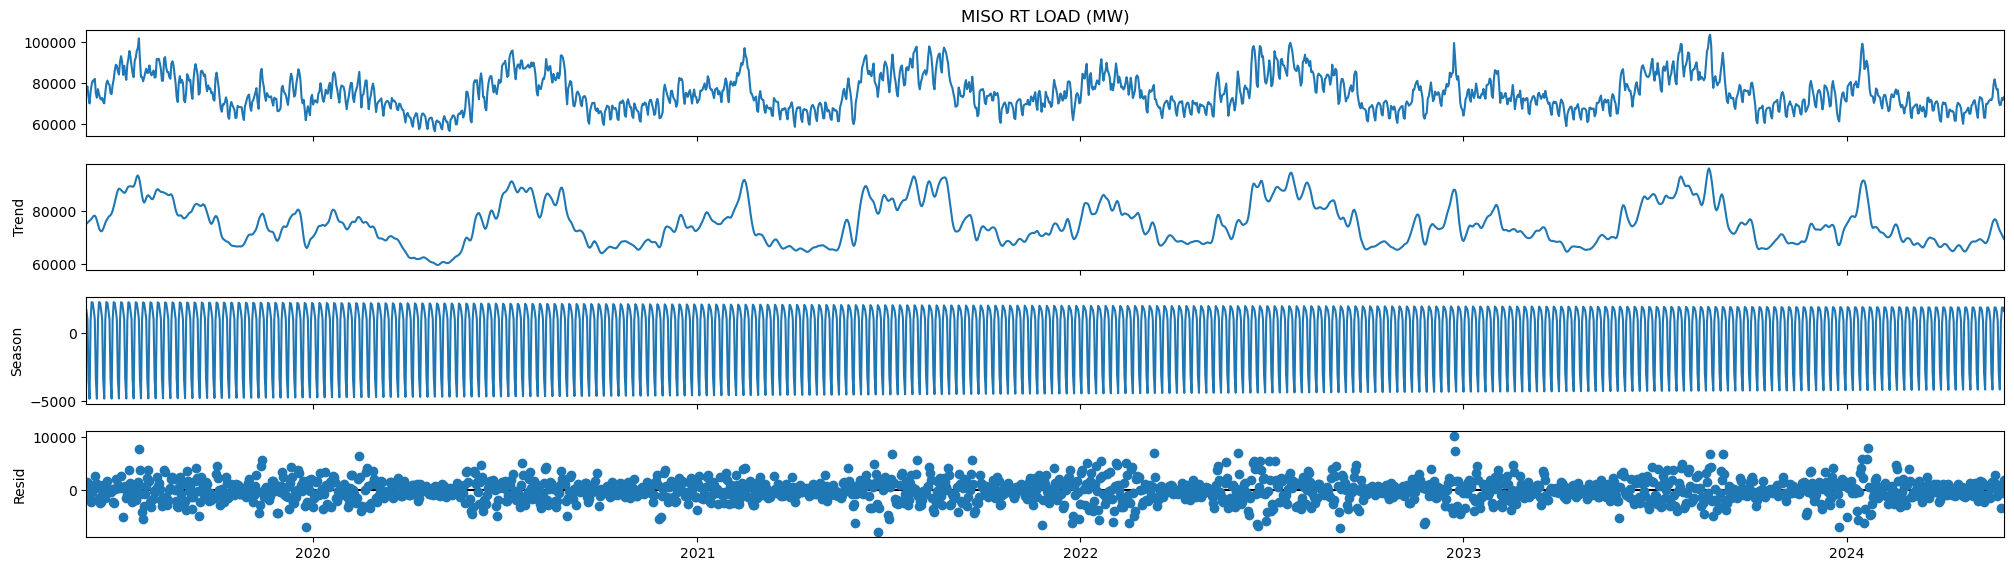

In [6]:
df_daily = df.resample('D').mean()
load_daily=df_daily['MISO RT LOAD (MW)']

stl = STL(load_daily.dropna(),seasonal=365)
stl_result = stl.fit()

fig=stl_result.plot()
fig.set_size_inches(23,6)
plt.show()


### Autocorrelation analysis and SARIMA model
Next, we take a look at the ACF and PACF plots to examine autocorrelation in the data. This will help us determine parameter choices for our SARIMA(p,d,q)x(P,D,Q,S) As can be seen, the ACF plot exhibits a decaying behavior, suggesting that the data may be nonstationary. However, by the ADF test, we determined with high confidence that the data is stationary. The reason for this decaying behavior could be attributed to seasonal non-stationarity, as the intuitive reasoning behind this is that the distribution of the data indeed changes in accordance to the season; load consumption during the summer is going to be higher on average than it will be in the winter. For this reason, we set d=0 and D=1 to reflect the need for nonstationary differencing.

We can also see that the largest spikes in the corellograms occur at lag 1. For this reason, we can set the parameters P=Q=p=q=1.

For the seasonality parameter, we choose S=7 for two reasons. The first is due to constraints on the algorithm, it is unable to take S=1 as a parameter. Secondly load patterns tend to also exhibit weekly and annually seasonality, making S=7 and S=365 feasible choices for the model. For the sake of computational complexity, we will choose S=7.

This brings us to the model SARIMA(1,0,1)x(1,1,1,7). This is the model that will be used for question 2.

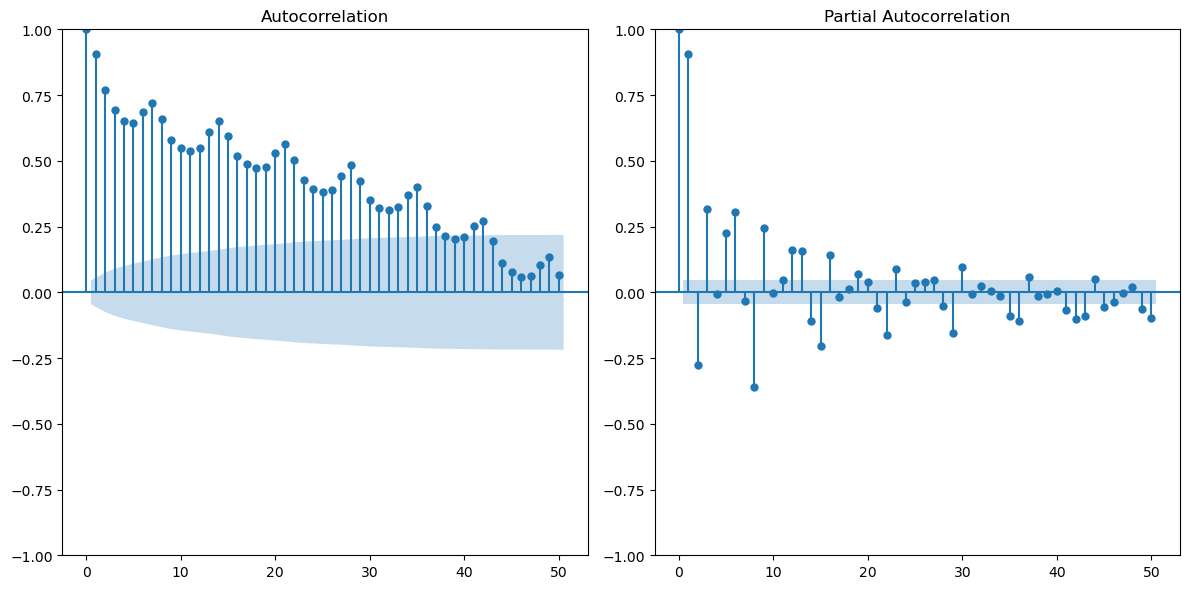

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(load_daily, lags=50, ax=ax[0])
plot_pacf(load_daily, lags=50, ax=ax[1])

plt.tight_layout()
plt.show()

## 2. 
### Regression model
For the regression model, I've chosen a dynamic regression model with SARIMA errors, where we regress on our independent variables (temperature, snowfall, windspeed) along with lags of the RT Load variable. A dynamic regression model is a more appropriate choice since the data clearly exhibits seasonal patterns. No differencing was performed, as we determined that each series is stationary. The equation of the model is as follows:

\begin{align}
Y_t = \alpha + \beta_1 \cdot \text{Temperature}_t + \beta_2 \cdot \text{Snowfall}_t + \beta_3 \cdot \text{WindSpeed}_t + \phi_1 Y_{t-1} + \theta_1 \epsilon_{t-1} + \Phi_1 Y_{t-7} + \Theta_1 \epsilon_{t-7} + \epsilon_t
\end{align}

where:

- $\alpha$ is the intercept
- $\beta_1 , \beta_2 , \beta_3$ are coefficients for the contemporaneous values of Temperature, Snowfall, and Wind Speed, respectively
- $\phi_1$ is the non-seasonal AR(1) parameter
- $\theta_1$ is the non-seasonal MA(1) parameter
- $\Phi_1$ is the seasonal AR(1) parameter at lag 7 (representing weekly seasonality)
- $\Theta_1$ is the seasonal MA(1) parameter at lag 7
- $\epsilon_t$ is the error term at time $t$

Seasonality was addressed by using a SARIMA model as opposed to a non-seasonal ARIMA model that did not include seasonal ARMA terms (of weekly seasonality) or seasonal differencing. These addition of seasonality parameters were applied to address non-stationarity that arises from weakly seasonality.

Non-seasonal ARMA terms, namely the AR(1) and MA(1) terms, were used to address autocorrelation in the residuals. The selection of these parameters was determined by the ACF/PACF plots above. 

### Structural breaks
**NOTE:** Python has no built-in package for structural break testing, so this part of the analysis was outsourced to a separate R file.

Using the strucchange package in R, we are able to estimate the breakpoints in the linear model of the regressors on RT Load. The test yields a result of an optimal number of 4 breaks occurring on days 462, 736, 1199, 1475 from 5/30/2019. This is where the BIC criterion is minimized, making it optimal to the linear model. Below are the equations for the resulting models.

**Regime 1: Before Break 1** 

\begin{align}
Y = \beta_{0,1} + \beta_{1,1} \cdot \text{Temperature} + \beta_{2,1} \cdot \text{Snowfall} + \beta_{3,1} \cdot \text{Wind Speed} + \epsilon
\end{align}

**Regime 2: Between Break 1 and Break 2** 

\begin{align}
Y = \beta_{0,2} + \beta_{1,2} \cdot \text{Temperature} + \beta_{2,2} \cdot \text{Snowfall} + \beta_{3,2} \cdot \text{Wind Speed} + \epsilon
\end{align}

**Regime 3: Between Break 2 and Break 3** 

\begin{align}
Y = \beta_{0,3} + \beta_{1,3} \cdot \text{Temperature} + \beta_{2,3} \cdot \text{Snowfall} + \beta_{3,3} \cdot \text{Wind Speed} + \epsilon
\end{align}

**Regime 4: Between Break 3 and Break 4** 

\begin{align}
Y = \beta_{0,4} + \beta_{1,4} \cdot \text{Temperature} + \beta_{2,4} \cdot \text{Snowfall} + \beta_{3,4} \cdot \text{Wind Speed} + \epsilon
\end{align}

**Regime 5: After Break 4** 

\begin{align}
Y = \beta_{0,5} + \beta_{1,5} \cdot \text{Temperature} + \beta_{2,5} \cdot \text{Snowfall} + \beta_{3,5} \cdot \text{Wind Speed} + \epsilon
\end{align}

where:
- $\beta_{0,i}$: Intercept for regime $i$
- $\beta_{1,i}$: Coefficient for Temperature in regime $i$
- $\beta_{2,i}$: Coefficient for Snowfall in regime $i$
- $\beta_{3,i}$: Coefficient for Wind Speed in regime $i$
- $\epsilon$: Error term



In [8]:
X = sm.add_constant(df[['Temperature (F)', 'Snowfall (inch)', 'Wind Speed (mph)']]).dropna()

sarima_model = SARIMAX(
    df['MISO RT LOAD (MW)'],
    exog=X,
    order=(1, 0, 1),                 
    seasonal_order=(1, 1, 1, 7),   
    enforce_stationarity=False,
).fit()

# Summary of the SARIMA model
print(sarima_model.summary())


KeyboardInterrupt: 

### Regression results
From the regression results, we can see that 2/3 of our exogenous variables are statistically significant. Snowfall is not statistically significant on the 95% CI. Both our seasonal and nonseasonal ARMA terms are statistically significant, meaning that both weakly cyclical effects and 1-period (1-day) lag effects are statistically significant to the behavior of the series. The constant, however, seems to be completely random and insignificant. This could be due to stationarity, overfitting the model, multicollinearity, or other models, so that is an issue that needs to be addressed.

The model diagnostics indicate that the model performance is subpar. The LB test indicates that there still remains serial autocorrelation in the data. This can be further addressed by adding additional higher-order AR/MA terms or additional seasonal lags. Also, the JB test indicates that the model residuals are not normally distributed, which could arise from a weak model that is not able to capture the effects of outliers or nonlinear patterns.

## 3.
### VAR Model
For this part, we will be estimating a VAR model for our data. As discussed earlier, the data is clearly seasonal. We will control for the seasonality by using the seasonal decomposition method. We will take the residuals from this seasonal decompostion to use for the model, as these will lack the seasonal components of the data. This will allow the model fitting to focus on the non-seasonal autoregressive dependencies of the data. Using BIC, we determined that the optimal lag length is 27. So that brings us to the following equation:

\begin{align}

Y_t = \begin{bmatrix} \alpha_1 \\ \alpha_2 \\ \alpha_3 \\ \alpha_4 \end{bmatrix} + 
\sum_{i=1}^{27}
\begin{bmatrix} 
\phi_{1,i} & \theta_{1,i} & \gamma_{1,i} & \delta_{1,i} \\ 
\phi_{2,i} & \theta_{2,i} & \gamma_{2,i} & \delta_{2,i} \\ 
\phi_{3,i} & \theta_{3,i} & \gamma_{3,i} & \delta_{3,i} \\ 
\phi_{4,i} & \theta_{4,i} & \gamma_{4,i} & \delta_{4,i} 
\end{bmatrix} Y_{t-i} 
+
\begin{bmatrix} \epsilon_{1,t} \\ \epsilon_{2,t} \\ \epsilon_{3,t} \\ \epsilon_{4,t} \end{bmatrix}

\end{align}

where:

-  $\alpha_i$  in vector  $C$  represents the intercept for the corresponding equation.
- Each  $A_i$  matrix contains the coefficients:
  -  $\phi_{j,i}$ : coefficient for the  $j$ -th variable’s own lag  $i$ 
  -  $\theta_{j,i}$ : coefficient for **Temperature** (X1) lag  $i$ 
  -  $\gamma_{j,i}$ : coefficient for **Snowfall** (X2) lag  $i$ 
  -  $\delta_{j,i}$ : coefficient for **WindSpeed** (X3) lag  $i$ 



In [28]:
# Seasonally decompose each series and collect residuals 
residuals = pd.DataFrame()
for column in df.columns[:4]:  
    decomposition = seasonal_decompose(df[column], model='additive', period=7)  
    residuals[column] = decomposition.resid

residuals.dropna(inplace=True)


# Fit VAR model on seasonal decomposition residuals
model = VAR(residuals)  
lag_order = model.select_order(maxlags=50)  

# Select optimal lag length based on BIC
optimal_lag = lag_order.bic

# Fitting VAR model 
var_model = model.fit(optimal_lag)

# Display the summary of the fitted model
print(var_model.summary())




  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 10, Nov, 2024
Time:                     23:28:44
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    3.14725
Nobs:                     43816.0    HQIC:                   3.03807
Log likelihood:          -313342.    FPE:                    19.8426
AIC:                      2.98783    Det(Omega_mle):         19.4826
--------------------------------------------------------------------
Results for equation MISO RT LOAD (MW)
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        -0.048859         1.291072           -0.038           0.970
L1.MISO RT LOAD (MW)          1.142470         0.004746          240.722           0.000
L1.Temperature (

### Residual plots analysis
The plot in the top left corner is the residual time series for MISO RT Load. The residual series seems to fluctuate around zero and seems to be a stationary series. This is perhaps a good sign, as it seems to have removed seasonal patterns and trends from the series. There do seem to be some extreme outliers, which could be due to extreme events of exogenous processes.

The top right is a histogram of the residuals. The distribution seems to be centered around 0, which is a desired result. However, it is clearly leptokurtic to the naked eye, entailing that this model is sensitive to extreme outliers. The model may not be able to explain and account for the risky nature of load forecasting.

The ACF and PACF plots have some small spikes around the lag range that the model uses (24-30). The spikes don't seem to deviate far from 0, however, so it would seem that there is little serial autocorrelation in the residuals.

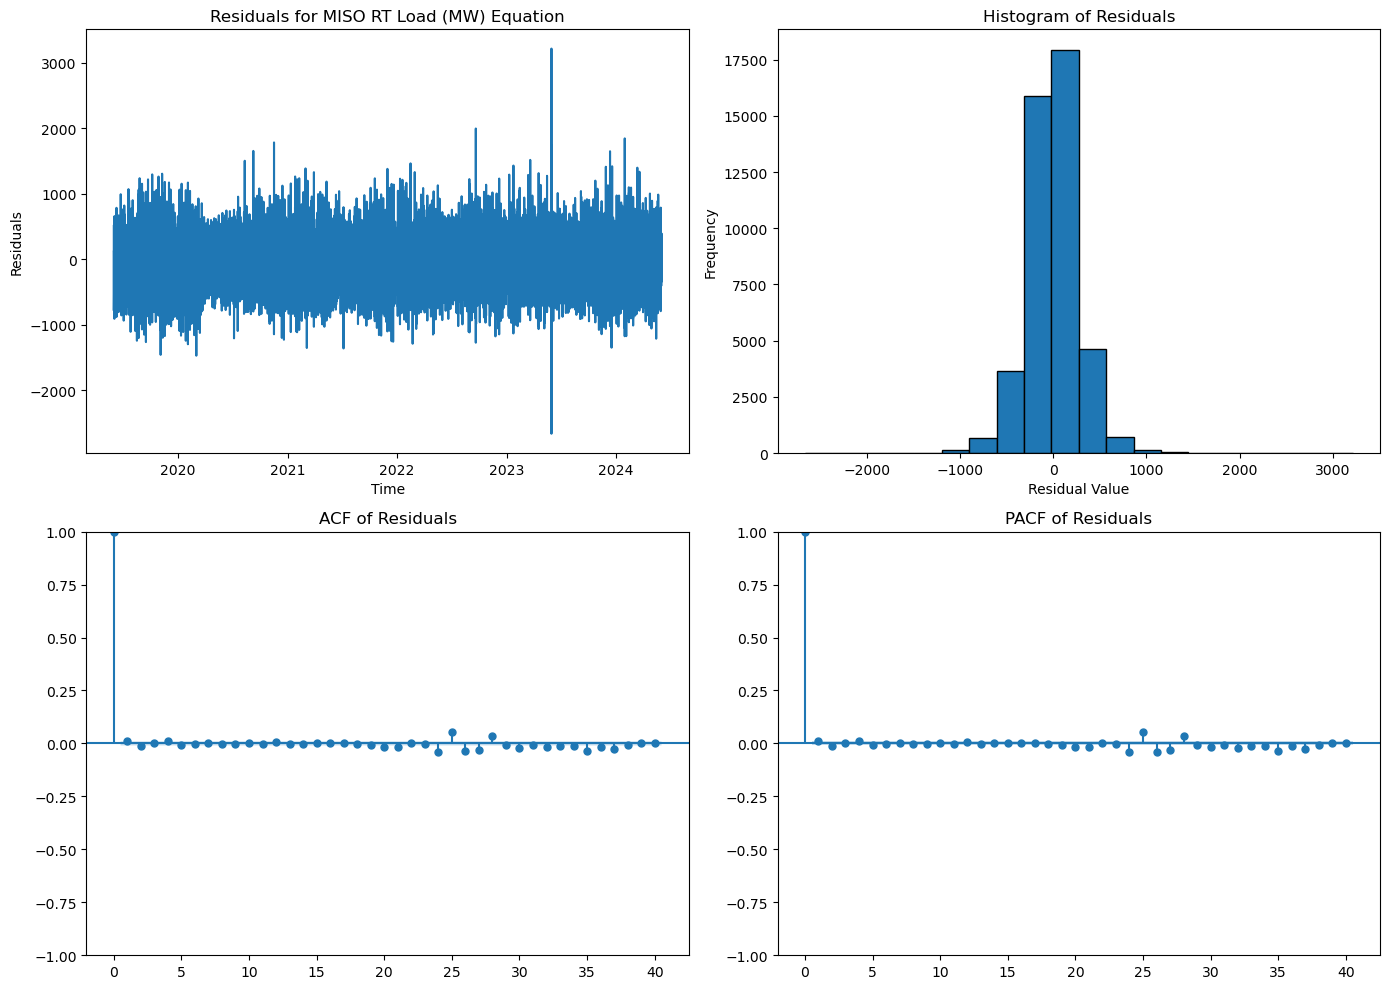

In [36]:
# RT Load residuals
rt_load_residuals = var_model.resid['MISO RT LOAD (MW)']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residual time series plot
axes[0, 0].plot(rt_load_residuals)
axes[0, 0].set_title("Residuals for MISO RT Load (MW) Equation")
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Residuals")

# Residual histogram
axes[0, 1].hist(rt_load_residuals, bins=20, edgecolor='black')
axes[0, 1].set_title("Histogram of Residuals")
axes[0, 1].set_xlabel("Residual Value")
axes[0, 1].set_ylabel("Frequency")

# ACF plot
sm.graphics.tsa.plot_acf(rt_load_residuals, lags=40, ax=axes[1, 0])
axes[1, 0].set_title("ACF of Residuals")

# PACF plot
sm.graphics.tsa.plot_pacf(rt_load_residuals, lags=40, ax=axes[1, 1])
axes[1, 1].set_title("PACF of Residuals")

# Adjust layout
plt.tight_layout()
plt.show()



### Granger Causality test
The Granger Causality test will be applied to temperature to test for the significance of the causal effect of temperature. The output shows p-values ≈0 for the F-tests at lags 1-30. This entails that temperature has significant causal effect for lags 1-30.

In [ ]:
data_for_gc = df[['MISO RT LOAD (MW)', 'Temperature (F)']]

# Drop any NaN values (if any exist)
data_for_gc.dropna(inplace=True)
granger_test_results = grangercausalitytests(data_for_gc, maxlag=30)
print(granger_test_results)

### IRF and OIRF
Below are the plots of the 2-period reduced form IRF and the 2-period orthogonalized IRF. We consider the effects of a shock on the temperature variable onto the MISO RT Load variable, as that is the primary exogenous impulse response that we are examining. As we can see, the reduced form IRF is smaller in magnitude than the orthogonalized IRF. This is because the orthogonalized IRF isolates the effects of the shocks of temperature by assuming the shocks of temperature affect RT load and not vice versa. This difference makes the orthogonalized IRF preferrable option for this analysis. Temperature is an exogenous process that immediately affects load on a grid. It is not an endogenous variable that is contemperaneously affected by load. Using the reduced form IRF effectively reduces the effect of temperature on RT load, which would cause us to underestimate the effect in our analysis.

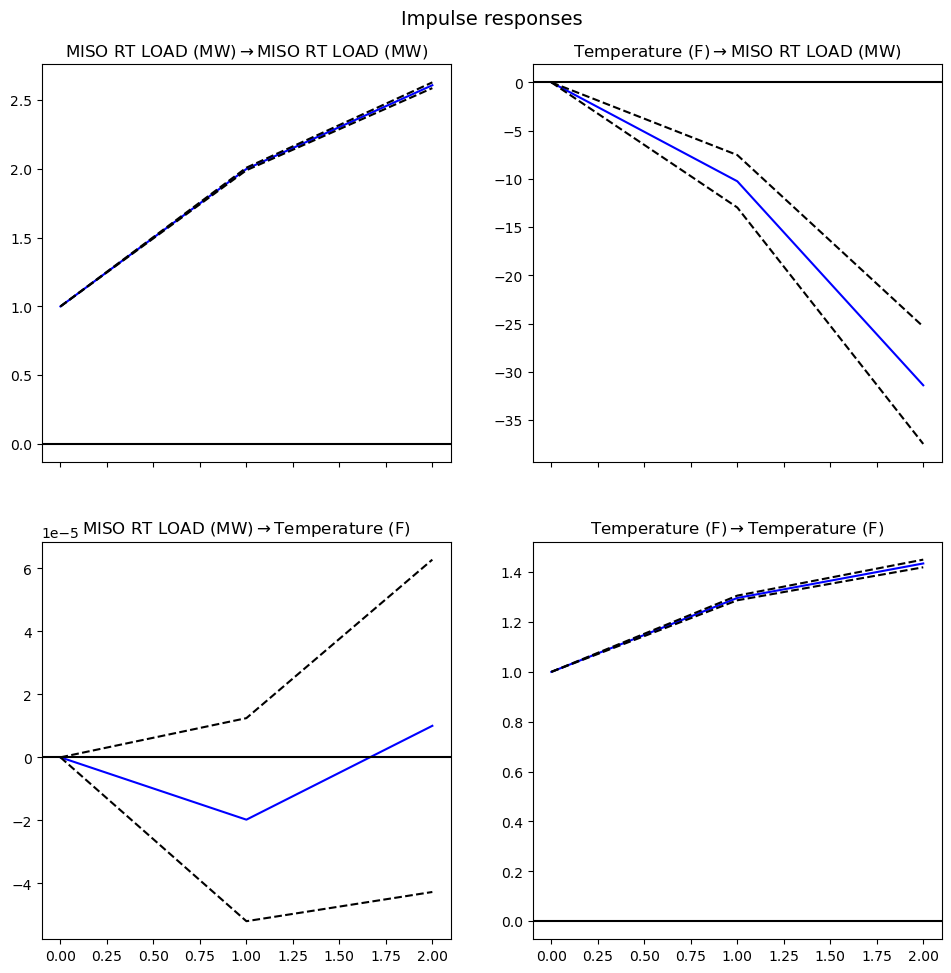

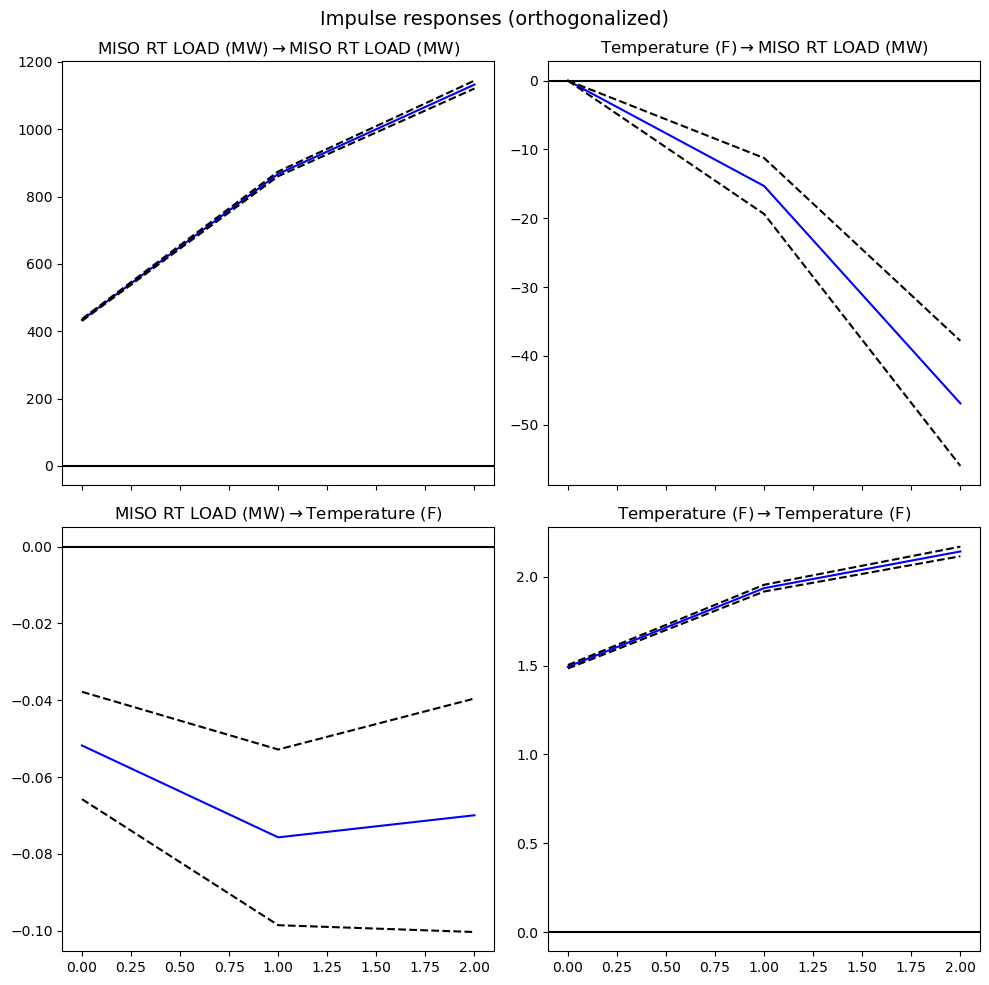

In [42]:
# Fit a VAR model with the two selected variables
model = VAR(data_for_gc)

# Select the optimal lag length with BIC
lag_order = model.select_order(maxlags=30)
optimal_lag = lag_order.bic  
var_model = model.fit(optimal_lag)

# Calculate the impulse response functions for 10 steps ahead
irf_reduced = var_model.irf(2)  # Reduced-form (non-orthogonalized) IRF
irf_orthogonal = var_model.irf(2)  # Orthogonalized (structural) IRF

# Reduced IRF
irf_reduced.plot(orth=False)

# Orthogonalized (structural) IRF
irf_orthogonal.plot(orth=True)

plt.tight_layout()
plt.show()
